# Install dependencies

In [1]:
!sudo apt-get install libgeos-3.6.2 libgeos-c1v5 libgeos-dev
!pip install geopandas

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-3.6.2 is already the newest version (3.6.2-1build2).
libgeos-c1v5 is already the newest version (3.6.2-1build2).
libgeos-dev is already the newest version (3.6.2-1build2).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.


In [2]:
! pip install descartes

In [11]:
! pip3 install --upgrade h5py netcdf4


Requirement already up-to-date: h5py in /root/.local/lib/python3.6/site-packages (2.9.0)
Requirement already up-to-date: netcdf4 in /root/.local/lib/python3.6/site-packages (1.4.3.2)


# Exploring Level2 MODIS Aqua data

In [0]:
import math
import numpy as np
import requests
from PIL import Image
from io import BytesIO
import matplotlib as mlp
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import datetime

In [117]:
!ls -lha 

total 57M
drwxr-xr-x 1 root root 4.0K Mar 10 04:38 .
drwxr-xr-x 1 root root 4.0K Mar 10 04:11 ..
-rw-r--r-- 1 root root 8.5M Feb 12 23:38 A2018345.L3m_DAY_CHL_chl_ocx_4km.nc
-rw-r--r-- 1 root root  31M Feb 12 23:32 A2018347.L3b_DAY_CHL.nc
drwxr-xr-x 1 root root 4.0K Feb 26 17:33 .config
-rw-r--r-- 1 root root 8.7M Feb 12 23:40 data
-rw-r--r-- 1 root root 8.7M Feb 12 23:40 data.nc
drwxr-xr-x 1 root root 4.0K Feb 26 17:33 sample_data


In [0]:
today = datetime.datetime.today()

In [0]:
toyday = today.timetuple().tm_yday

In [138]:
#!wget https://oceandata.sci.gsfc.nasa.gov/cgi/getfile/A2018346.L3m_DAY_CHL_chl_ocx_4km.nc -O data2.nc 
! wget https://oceandata.sci.gsfc.nasa.gov/cgi/getfile/V2018345.L3m_DAY_SNPP_CHL_chlor_a_4km.nc -O data.nc

--2019-03-10 05:19:49--  https://oceandata.sci.gsfc.nasa.gov/cgi/getfile/V2018345.L3m_DAY_SNPP_CHL_chlor_a_4km.nc
Resolving oceandata.sci.gsfc.nasa.gov (oceandata.sci.gsfc.nasa.gov)... 169.154.128.84, 2001:4d0:2418:128::84
Connecting to oceandata.sci.gsfc.nasa.gov (oceandata.sci.gsfc.nasa.gov)|169.154.128.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9361326 (8.9M) [application/octet-stream]
Saving to: ‘data.nc’

data.nc             100%[===================>]   8.93M  10.3MB/s    in 0.9s    

2019-03-10 05:19:59 (10.3 MB/s) - ‘data.nc’ saved [9361326/9361326]



In [0]:
# d.close()
# ! rm data.nc

In [0]:
d = Dataset("./data.nc", "r", format="NETCDF4")

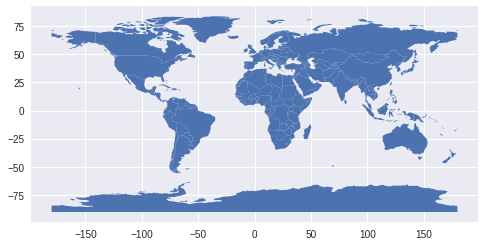

In [6]:
import geopandas as gp
world = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))
world.plot()

In [0]:
lon_range = [-94,-87] # [-92.32910156250001, -90.6976318359375]
lat_range = [12,18] # [ 13.159725022841753,  14.689881366618774]

In [160]:
lons = np.argwhere((d.variables["lon"][:]>lon_range[0]) & (d.variables["lon"][:]<lon_range[1]))
lats = np.argwhere((d.variables["lat"][:]>lat_range[0]) & (d.variables["lat"][:]<lat_range[1]))
gtsubset = d.variables["chlor_a"][min(lats)[0]:max(lats)[0],min(lons)[0]:max(lons)[0]]
print(gtsubset.shape)

(143, 167)


0

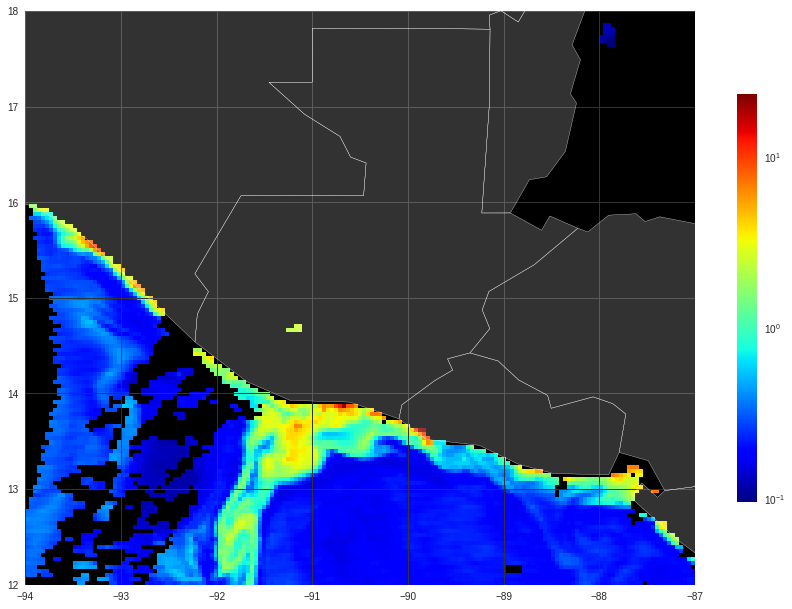

In [168]:
mlp.rcParams["figure.figsize"] = (15, 15)
mlp.rcParams["grid.color"] = "#33333322"
world.plot(color="#ffffff33", edgecolor="#ffffffff")
plt.xlim(lon_range[0], lon_range[1])
plt.ylim(lat_range[0], lat_range[1])
#plt.imshow(im)
cmap = mlp.cm.jet
cmap.set_bad('black',1.)
plt.imshow(gtsubset, cmap = cmap, extent=(lon_range[0], lon_range[1], lat_range[0], lat_range[1]), 
                    norm=mlp.colors.LogNorm(vmin=gtsubset.min(), vmax=gtsubset.max()) )
plt.colorbar(shrink=0.5)
0

In [0]:
def deg2num(lat_deg, lon_deg, zoom):
  lat_rad = math.radians(lat_deg)
  n = 2.0 ** zoom
  xtile = int((lon_deg + 180.0) / 360.0 * n)
  ytile = int((1.0 - math.log(math.tan(lat_rad) + (1 / math.cos(lat_rad))) / math.pi) / 2.0 * n)
  return (xtile, ytile)

def num2deg(xtile, ytile, zoom):
  n = 2.0 ** zoom
  lon_deg = xtile / n * 360.0 - 180.0
  lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * ytile / n)))
  lat_deg = math.degrees(lat_rad)
  return (lat_deg, lon_deg)



def getImageCluster(lat_deg, lon_deg, delta_lat,  delta_long, zoom):
    smurl = r"http://a.tile.openstreetmap.org/{0}/{1}/{2}.png"
    xmin, ymax =deg2num(lat_deg, lon_deg, zoom)
    xmax, ymin =deg2num(lat_deg + delta_lat, lon_deg + delta_long, zoom)

    Cluster = Image.new('RGB',((xmax-xmin+1)*256-1,(ymax-ymin+1)*256-1) ) 
    for xtile in range(xmin, xmax+1):
        for ytile in range(ymin,  ymax+1):
            imgurl=smurl.format(zoom, xtile, ytile)
            # print("Opening: " + imgurl)
            imgstr = requests.get(imgurl).content
            tile = Image.open(BytesIO(imgstr))
            Cluster.paste(tile, box=((xtile-xmin)*256 ,  (ytile-ymin)*255))

    return Cluster, [num2deg(xmin, ymax+1, zoom), num2deg(xmax+1, ymin, zoom)]

In [0]:
mapbg, bbox = getImageCluster(lat_range[0], lon_range[0], lat_range[1]-lat_range[0], lon_range[1]-lon_range[0], 7)

In [217]:
bbox

[(11.178401873711781, -95.625), (19.31114335506464, -84.375)]

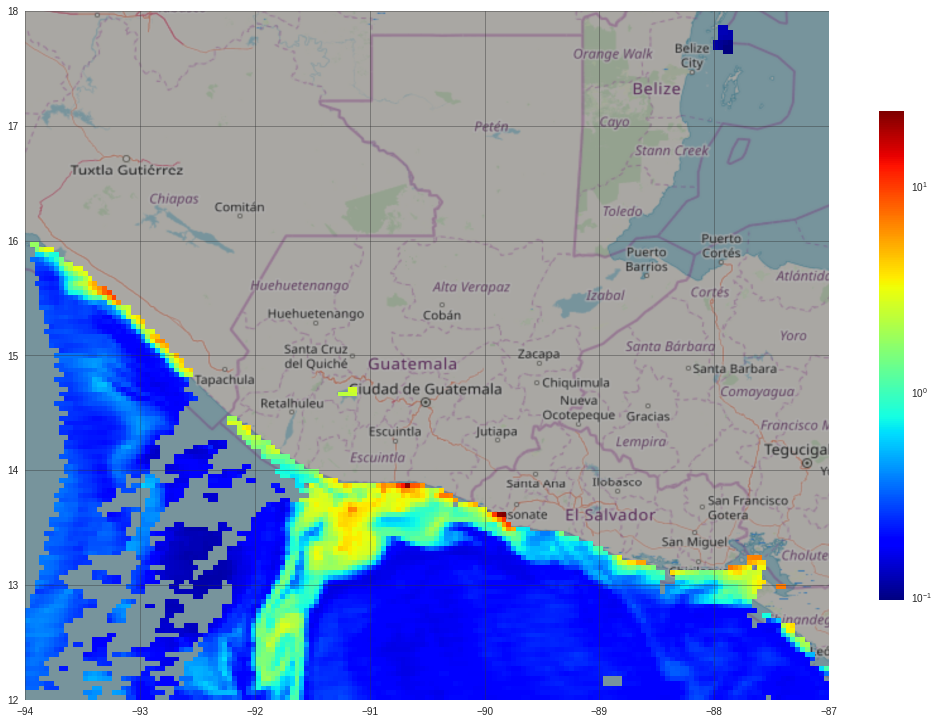

0

In [227]:
mlp.rcParams["figure.figsize"] = (18, 18)
mlp.rcParams["grid.alpha"] = 0.4
fig,ax = plt.subplots()
plt.xlim(lon_range[0], lon_range[1])
plt.ylim(lat_range[0], lat_range[1])
cmap = mlp.cm.jet
cmap.set_bad('black',0.3)
ax.imshow(mapbg, extent=(bbox[0][1], bbox[1][1], bbox[0][0], bbox[1][0]), interpolation = "gaussian")
satimg = ax.imshow(gtsubset, cmap = cmap, extent=(lon_range[0], lon_range[1], lat_range[0], lat_range[1]), 
                    norm=mlp.colors.LogNorm(vmin=gtsubset.min(), vmax=gtsubset.max()) )
plt.colorbar(satimg, shrink=0.5)

plt.show()
0

In [225]:
gtsubset.mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])